In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Gravitational Waves
<br>
__Problem Description__ : 

Gravitational waves are ripples in space and time which are generated by motion of accelerated object(s). Extremely massive compact object, such as black holes and neutron stars, are one of the strongest sources of gravitational waves in form of binaries. As these objects rotate around each other, they alter the curvature of space-time creating ripples much like the ripples generate in water due to motion of two boats in a circle. These ripples contains the information of their sources and can travel for millions of light years without loosing their original form. Today, using gravitational wave detectors, we can learn more about the universe and locate several hidden objects such as black holes. 

One of the challenges in these observations is to identify the source and source parameters from the signal. In other words, once we detect a gravitational wave signal, what can we tell about the system which created these ripples? Was it from a binary black hole or from two neutron stars? If it was a binary black hole, what were the masses and spins of the binary? What happened after the merger? In this short work, I will use machine learning as an alternate method to tackle this problem. 



__Dataset__ :

Here, we use a publicly available dataset of gravitational waveforms of binary black holes from three numerical relativity groups. The data can be downloaded from - 
*
*
*
The waveforms are generated using numerical simulations of binary black holes and contain the plus and cross polarizations of wave as a function of time along with metadata files containing details about the original source. There are a total of ... waveforms. The data has already undergone initial cleaning which mean centers the data along the peak of amplitude and have same time duration before and after the merger, length of which is determined from shortest available  waveform. 

__Method__:

The aim of this work is to use these time series waveforms as training dataset and apply supervised machine learning methods to predict the type of Binary black hole configuration. In this notebook we focus on dimensionality reduction methods. 

In [106]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/watch?v=_GhkWuIDzpc" frameborder="0" allowfullscreen></iframe>')


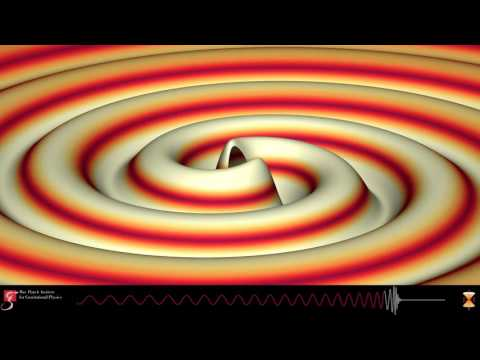

In [108]:
from IPython.display import YouTubeVideo

YouTubeVideo('_GhkWuIDzpc', width=800, height=300)


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylab as P
import time, glob, os, math
from matplotlib import cm 
from itertools import cycle
from collections import OrderedDict

import matplotlib as mpl
mpl.rc('lines', linewidth=2, color='r')
mpl.rc('font', size=16)
mpl.rc('axes', labelsize=16, grid=True)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('legend', fontsize=14)

from sklearn.decomposition import PCA, FastICA, KernelPCA, FactorAnalysis
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.random_projection import GaussianRandomProjection
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.mixture import GaussianMixture as GM
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier as DT

In [92]:
import sklearn
print(sklearn.__version__)

0.19.1


In [2]:
#Basic Functions and Classes

def read_paramvalue(metafile, parameter):
    '''Return the parameter value from data
    
    Parameters:
    metafile (str) - Metadata filepath
    parameter (str) - parameter name
    '''
   
    assert(os.path.exists(metafile)),"Path to metadata file does not exist"
    
    datafile = open(metafile,'r')
    datafile.seek(0)
    for line in datafile:
        if parameter in line:
            break
    
    line = line.split(',')
    
    #rstrip - remove any trailing charaters
    data_value = line[-1].rstrip()
    datafile.close()
    return data_value


def plot(x, y, xlabel, ylabel, xlim=None, ylim=None, log=None, title=None):     #Create a plot
    '''Generate a line plot of y vx x
    
    Parameters - 
    x,y - Dictionaries - {'label_1':data_1,...'label_n':data_n} - Ensure x and y have same keys/labels
    xlabel, ylabel - strings
    '''
    plt.figure(figsize=(12,6))
    lines = ["-","--","-.",":"]
    linecycler = cycle(lines)
    for key in x:
        plt.plot(x[key], y[key], ls=next(linecycler), label=key)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xlim!=None:
        plt.xlim(xlim[0],xlim[1])
    if ylim!=None:
        plt.ylim(ylim[0],ylim[1])
        
    if log=='x': plt.xscale('log')
    elif log=='y': plt.yscale('log')
    elif log=='both': 
        plt.xscale('log')
        plt.yscale('log')
        
    if title!=None:
        plt.title(title, y=1.04, fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()
    
    
def scatter(ax, x, y, clr, xlabel, ylabel, title=None, legend=True):     #Create a scatter plot
    '''Generate a scatter plot 
       ax - subplot
       x, y - numpy arrays
       xlabel, ylabel title - strings  
    '''
    clr_label = {0:'orange', 1:'forestgreen', 2:'deepskyblue',3:'gold', 4:'b', 5:'k', 6:'red', 7:'darkmagenta' }
    names = {'AlignedSpins':0,'NonSpinning':1,'Precessing':2}
    #target_names = np.vectorize(names.get)(clr)
    target_labels =  np.vectorize(clr_label.get)(clr) #(target_names)
   
    ax.scatter(x,y,facecolors=target_labels, edgecolors=None) 

    orange_dot= plt.scatter([], [], color=clr_label[0], label='AlignedSpin')
    green_dot= plt.scatter([], [], color=clr_label[1], label='NonSpinning')
    blue_dot= plt.scatter([], [], color=clr_label[2], label='Precessing')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title!=None:
        ax.set_title(title)
    if legend: ax.legend(handles=[orange_dot, green_dot, blue_dot])
    return ax


class waveform():
    
    def __init__(self, wf_filepath, wf_metadata_file):
        
        assert os.path.exists(wf_filepath), "Waveform file at path %s not found"%wf_filepath
            
        self.t, self.hp, self.hx = np.loadtxt(wf_filepath, unpack=True, usecols=(0,1,2))
        
        self.dt  = self.t[2]-self.t[1]
        
        self._amplitude  = np.sqrt(self.hp**2 + self.hx**2)
        self._phase = -1.*np.unwrap(np.arctan2(self.hp,self.hx))
        self._gwfreq  = np.gradient(self.phase)/np.gradient(self.t)
        
        self._freq, self._hf_plus, self._hf_cross = self.fourier_transform()
        self._hf_amplitude = np.sqrt(np.absolute(self._hf_plus)**2 + np.absolute(self._hf_cross)**2)
        
        #Read parameters from metadata file
        metafile = wf_metadata_file
        self.name =  read_paramvalue(metafile, 'name')
        
        self.m1 = read_paramvalue(metafile, 'mass1')
        self.m2 = read_paramvalue(metafile, 'mass2')
        
        self.a1x = read_paramvalue(metafile, 'spin1x')
        self.a1y = read_paramvalue(metafile, 'spin1y')
        self.a1z = read_paramvalue(metafile, 'spin1z')
        
        self.a2x = read_paramvalue(metafile, 'spin2x')
        self.a2y = read_paramvalue(metafile, 'spin2y')
        self.a2z = read_paramvalue(metafile, 'spin2z')
    
        self.ecc = read_paramvalue(metafile, 'eccentricity')
        self.spin_type = read_paramvalue(metafile, 'spin-type')
        self.f_low = read_paramvalue(metafile, 'f_lower_at_1MSUN')
        
    #Declare amplitude, phase and GW frequency as properties so any modification to strain data (for eg windowing)
    #is automatically accounted for. 
    
    def get_amplitude(self):
        return self._amplitude

    
    def set_amplitude(self): 
        print('Amplitude Setter function called')
        self._amplitude = np.sqrt(self.hp**2 + self.hx**2)

    amplitude = property(get_amplitude, set_amplitude)
    
    
    def get_phase(self):
        return self._phase

    def set_phase(self): 
        self._phase = -1.*np.unwrap(np.arctan2(self.hp, self.hx))
     
    phase = property(get_phase, set_phase)
    
    
    def get_gwfreq(self):
        return self._gwfreq

    def set_gwfreq(self): 
        self._gwfreq = np.gradient(self.phase)/np.gradient(self.t)

    gwfreq = property(get_gwfreq, set_gwfreq) 
    
    
    def  get_hf_plus(self):
        return self._hf_plus

    def set_hf_plus(self): 
        self._hf_plus = np.abs(np.fft.fft(self.hp))*self.dt
   
    hf_plus= property(get_hf_plus, set_hf_plus) 
    
    
    def get_hf_cross(self):
        return self._hf_cross

    def set_hf_cross(self): 
        self._hf_cross = np.abs(np.fft.fft(self.hx))*self.dt
    
    hf_cross= property(get_hf_cross, set_hf_cross) 
    
   
    def get_hf_amplitude(self):
        return self._hf_amplitude

    def set_hf_amplitude(self): 
        self._hf_amplitude = np.sqrt(np.absolute(self._hf_plus)**2 + np.absolute(self._hf_cross)**2)
    
    hf_amplitude= property(get_hf_amplitude, set_hf_amplitude) 
   
    def get_freq(self):
        return self._freq

    def set_freq(self): 
        self._freq = np.fft.fftfreq(len(self.hf_plus), self.dt)
   
    freq = property(get_freq, set_freq)
    
   
    def update_properties(self):
        print('Update properties called')
        t = self.t
        re = self.hp
        im = self.hx
       
        self.set_amplitude()
        self.set_phase()
        self.set_gwfreq()
        self.set_hf_plus()
        self.set_hf_cross()
        self.set_freq()
        
    def fourier_transform(self ):
        hf_plus  = np.abs(np.fft.fft(self.hp))*self.dt
        hf_cross = np.abs(np.fft.fft(self.hx))*self.dt
        hf = np.sqrt(hf_plus**2  + hf_cross**2)
        freq = np.fft.fftfreq(len(hf), self.dt)
        return freq, hf_plus, hf_cross

    def mean_centring(self):
        max_amp = np.amax(self.amp)
        tmax = self.t[amp==max_amp]
        self.t = self.t-tmax
        
         
    def window_beginning(self, window_length):
        old_t_start = t[0]
        new_t_start = old_t_start + window_length
        
        self.hp = self.hp[self.t>new_t_start]
        self.hx = self.hx[self.t>new_t_start]
        
        self.t = self.t[self.t>new_t_start]
        self.update_properties()
        
    def window_ends(self, window_length):
        old_t_end = t[-1]
        new_t_end = old_t_end - window_length
        
        self.hp = self.hp[self.t<new_t_end]
        self.hx = self.hx[self.t<new_t_end]
        
        self.t = self.t[self.t<new_t_end]
        



In [3]:
os.chdir('/localdata2/bkhamesra3/MachineLearning/GW-MLClassification/Data/')


# Gravitational Waves 

Mathematically, one can represent gravitational waves in form of time-dependent function called strain defined as 
$$h(t) = h_+(t) + \iota\, h_\times (t) = A(t) \; e^{\iota \phi(t)}$$

Figure 1 presents an example of gravitational wave signal scaled with the total mass of the binary ($M_{total} = 1$). The blue curve denotes the '+' polarization ($h_+(t)$) and orange curve denotes the amplitude. We can directy use these signals with each instant of time as out feature. But this will increase the dimensionality of dataset significantly. One can alternatively also look at this function in frequency domain. In Figure 2, we compute the power spectral density of strain. As can be seen from the plot below, only a certain range of frequency really holds relevant data which contributes to the power of the signal. Hence, it might be more efficient to use the frequency based data for further analysis and filter out the frequencies with low power contribution


We start by defining "waveform" class object which contains strain as time and frequency series and metadata about the initial binary configuration. We build an array of such class objects for each of the dataset. Note that throught some the initial cleaning, all datasets have been mean centered and have same time duration. We can consider each time instant as a feature and use Supervised ML methods. However, that would lead to enormous amount of features compared to the size of data points. Hence, we apply some dimensionality reduction techniques. 

In [4]:
#Loading the Dataset

waveform_collection = []
GT_filepaths = sorted(glob.glob("FilteredData/GT*.txt"))

SXS_filepaths = sorted(glob.glob("FilteredData/SXS*.txt"))


for wf_file_gt in GT_filepaths:
    
    metadata_file = os.path.join('Metadata','Metadata_'+os.path.basename(wf_file_gt).split('.txt')[0]+'.csv')
    wf = waveform(wf_file_gt, metadata_file)
   
    waveform_collection.append(wf)
    
for wf_file_sxs in SXS_filepaths:
    
    metadata_file = os.path.join('Metadata','Metadata_'+os.path.basename(wf_file_sxs).split('.txt')[0]+'.csv')
    wf = waveform(wf_file_sxs, metadata_file)
   
    waveform_collection.append(wf)
    


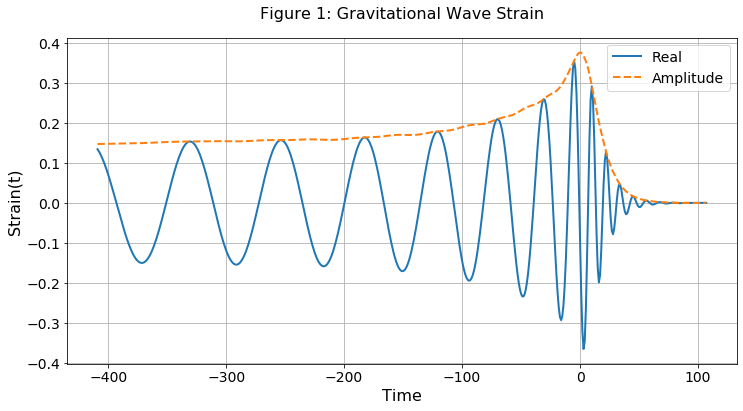

In [63]:
#Example Strain vs Time and Frequency plot
wf = waveform_collection[10]

x = {'Real':wf.t, 'Amplitude':wf.t}
y = {'Real':wf.hp, 'Amplitude':wf.amplitude}
plot(x, y, "Time", "Strain(t)", title="Figure 1: Gravitational Wave Strain")



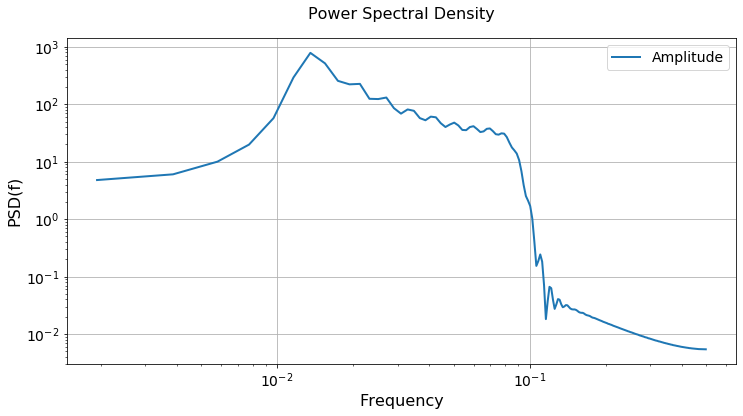

In [64]:
#Power Spectral Density

x = {'Amplitude':wf.freq[wf.freq>0]}
y = {'Amplitude':wf.hf_amplitude[wf.freq>0]**2}
plot(x, y, "Frequency", "PSD(f)", title="Power Spectral Density", log='both')



# Dimensionality Reduction 

We consider two different training datasets in time and frequency space - a concatenated array of the plus and cross polarization as function of time and frequency. Each instant of time for plus and cross polarizations serve as our feature space. The output is the type of Binary black hole configuration -  ('NonSpinning', AlignedSpin', 'Precessing'). As the output is string type, we convert it to integer labels using LabelEncoder(). Here we note that  all the waveforms have the same time and frequency components by the process of waveform generation. As a results, time and frequencies are not a varying feature and hence, need not be included as a feature. We then standardize the data and apply PCA and ICA to each of these methods and compare them with a classifier. 


In [65]:
# Construct Waveform dataset
# Dimensionality Reduction - https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e

def concat_wf_timedata(wf):
    '''Concatenate the time, real and imaginary components of waveform'''
    #print(wf.name, wf.spin_type)
    data = np.concatenate((wf.hp, wf.hx))
    
    return data

def concat_wf_freqdata(wf):
    '''Concatenate the time, real and imaginary components of waveform'''
    #print(wf.name, wf.spin_type)
    data = np.concatenate((np.absolute(wf.hf_plus)[wf.freq>0], np.absolute(wf.hf_cross)[wf.freq>0]))
    
    return data


waveform_collection  = np.asarray(waveform_collection)

# waveform_data_ht - each row represents concatenated data corresponding to one waveform in order (t, real, imag)
waveform_data_ht = list(map(concat_wf_timedata, waveform_collection))
waveform_data_ht = np.matrix(waveform_data_ht)

# waveform_data_hf - each row represents concatenated data corresponding to one waveform in order (f, FT(real), FT(imag))
waveform_data_hf = list(map(concat_wf_freqdata, waveform_collection))
waveform_data_hf = np.matrix(waveform_data_hf)

# Output
y = [wf.spin_type for wf in waveform_collection]


In [66]:
# Construct Training and test data for time series and standardize each
from sklearn import preprocessing

# Convert spin labels from string to numbers
le = preprocessing.LabelEncoder()
y_numeric = le.fit_transform(y)


#Split training and testing data
data_train_ht, data_test_ht, y_train_ht, y_test_ht = train_test_split(waveform_data_ht, y_numeric, train_size=0.85, random_state=12)

wf_test_prestd = np.reshape(data_train_ht[0], (np.size(data_train_ht[0]), 1))
idx = int(np.size(data_train_ht[0])/2)

plt.figure(figsize=(15,6))
plt.plot(waveform_collection[0].t, wf_test_prestd[:idx], label='Original Data')



#Standardize each feature of X and Y to have mean 0 and variance 1
SS_data =StandardScaler()
SS_y = StandardScaler()

data_train_ht =  SS_data.fit_transform(data_train_ht)
data_test_ht = SS_data.transform(data_test_ht)

wf_test_poststd = np.reshape(data_train_ht[0], (np.size(data_train_ht[0]), 1))
idx = int(np.size(data_train_ht[0])/2)


plt.plot(waveform_collection[0].t, wf_test_poststd[:idx], label='Normalized-Mean centered Data')
plt.xlabel('Time')
plt.ylabel('Strain Data')
plt.legend()
#plt.show()
plt.close()




/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [69]:
# Construct Training and test data for frequency series and standardize each
data_train_hf, data_test_hf, y_train_hf, y_test_hf = train_test_split(waveform_data_hf, y_numeric, train_size=0.85, random_state=12)


#Visualize the normalized data and compare with the original
wf_test_prestd = np.reshape(data_train_hf[0], (np.size(data_train_hf[0]), 1))
idx = int(np.size(data_train_hf[0])/2)
    
plt.figure(figsize=(15,6))
plt.plot(waveform_collection[0].freq[waveform_collection[0].freq>0], wf_test_prestd[idx:2*idx])
#plt.show()
plt.close()

#Standardize each feature of X and Y to have mean 0 and variance 1
SS_data =StandardScaler()
SS_y = StandardScaler()

data_train_hf =  SS_data.fit_transform(data_train_hf)
data_test_hf = SS_data.transform(data_test_hf)

for i in range(1):
    wf_test_poststd = np.reshape(data_train_hf[0], (np.size(data_train_hf[0]), 1))
    idx = int(np.size(data_train_hf[0])/2)

    
plt.figure(figsize=(15,6))
plt.plot(waveform_collection[0].freq[waveform_collection[0].freq>0], wf_test_poststd[idx:2*idx])
#plt.show()
plt.close()


/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## PCA 

Here we apply PCA to time and frequency series data and compare variance and variance ratio. We see that for time series data, most of the variance is included in first 45 components of PCA while in frequency series, one achieves this with just 7 PCA components. Visualizing each of the PCA components, however, we see that the segregation of BBH types is more easily seen with time-series based PCA in comparison with frequency based PCA. The precessing type BBH lie mostly along certain PCA component planes such as '0-1' plane compared to '0-2' or '0-3' etc. Such segregation does not stand out in frequency based dataset. 

In [102]:
%%time

# PCA_Analysis(data_train,y_train)

clf = PCA(svd_solver='full')
scores, pct_var, var = [], [], []
#data_copy = np.copy(data_train_ht)
numcomp = 10

clf.n_components = numcomp
transformed_data = clf.fit_transform(data_train_ht)
print(np.shape(data_train_ht), np.shape(transformed_data))

print(np.std(transformed_data, axis=0))

pct_var = 100.*clf.explained_variance_ratio_
var = clf.explained_variance_

    

(413, 1034) (413, 10)
[13.08828729 11.90536848  9.83785528  8.92186813  7.43393747  7.33570254
  6.86408013  5.99970284  5.85641261  5.62870736]
CPU times: user 419 ms, sys: 187 ms, total: 606 ms
Wall time: 78.9 ms


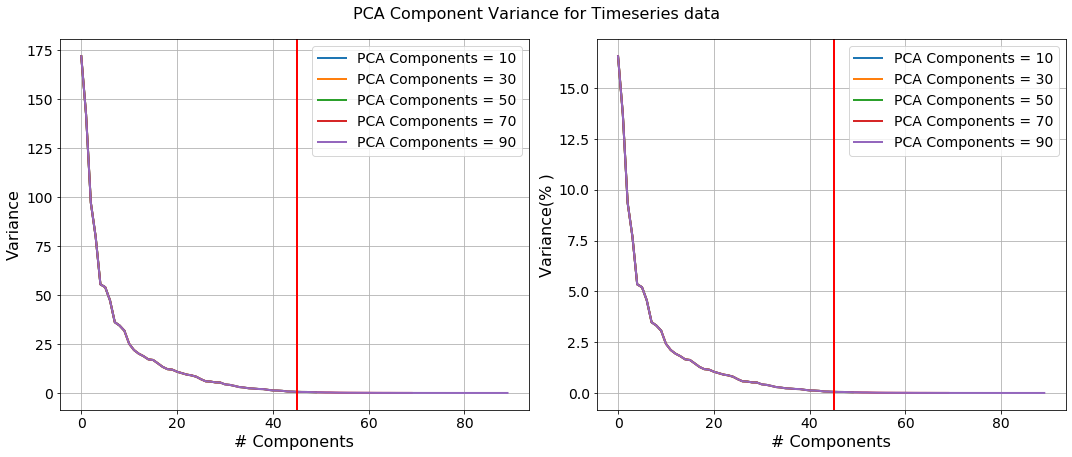

CPU times: user 13.1 s, sys: 6.52 s, total: 19.6 s
Wall time: 2.69 s


In [78]:
%%time

# PCA_Analysis(data_train,y_train)

clf = PCA(svd_solver='full')
scores, pct_var, var = [], [], []
#data_copy = np.copy(data_train_ht)
numcomp = np.arange(2,100,4)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))


for n in numcomp:
    clf.n_components = n
    transformed_data = clf.fit_transform(data_train_ht)
    
    pct_var = 100.*clf.explained_variance_ratio_
    var = clf.explained_variance_

    if n%10==0:
        ax1.plot(range(0, n), var[0:], label='PCA Components = %d'%n)
        ax1.set_xlabel('# Components')
        ax1.set_ylabel('Variance')
        ax1.axvline(x=45)
        ax1.legend()
        
        ax2.plot(range(0,n), pct_var[0:], label='PCA Components = %d'%n)
        ax2.set_xlabel('# Components')
        ax2.set_ylabel('Variance(% )')
        ax2.axvline(x=45)
        ax2.legend()
        
        plt.tight_layout()
    
fig.suptitle('PCA Component Variance for Timeseries data', y=1.05, fontsize=16)
plt.show()
#plt.savefig("Figures/PCA_AllbutFirstComp.png")
plt.close()


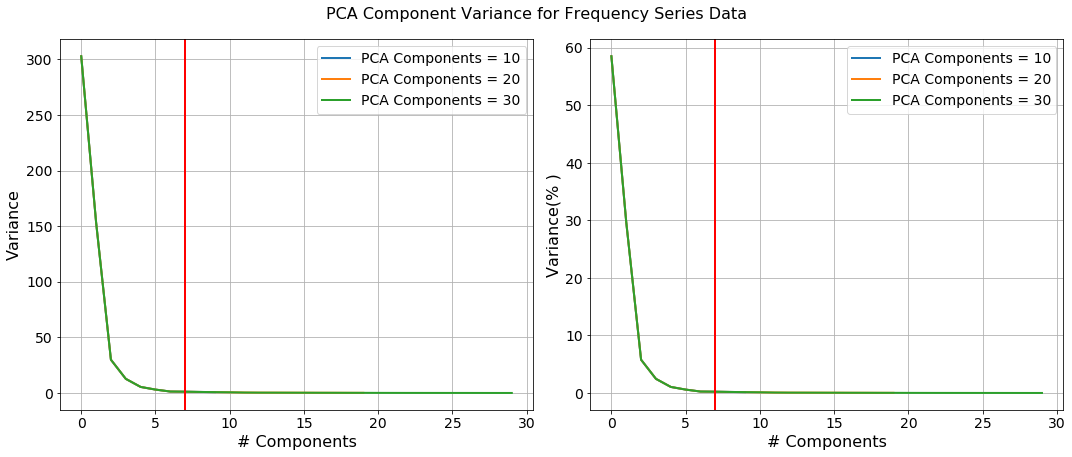

CPU times: user 6.48 s, sys: 3.34 s, total: 9.82 s
Wall time: 1.4 s


In [81]:
%%time
#PCA_Analysis(data_train,y_train)

clf = PCA(svd_solver='full')
scores, pct_var, var = [], [], []
numcomp = np.arange(2,40,2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))


for n in numcomp:
    clf.n_components = n
    transformed_data = clf.fit_transform(data_train_hf)
    
    pct_var = 100.*clf.explained_variance_ratio_
    var = clf.explained_variance_

    if n%10==0:
        ax1.plot(range(0, n), var[0:], label='PCA Components = %d'%n)
        ax1.set_xlabel('# Components')
        ax1.set_ylabel('Variance')
        ax1.legend()
        ax1.axvline(7)
        
        ax2.plot(range(0,n), pct_var[0:], label='PCA Components = %d'%n)
        ax2.set_xlabel('# Components')
        ax2.set_ylabel('Variance(% )')
        ax2.axvline(7)
        ax2.legend()
        
        plt.tight_layout()
    
fig.suptitle('PCA Component Variance for Frequency Series Data', y=1.05, fontsize=16)
plt.show()
#plt.savefig("Figures/PCA_AllbutFirstComp.png")
plt.close()




PCA for Time Based Data


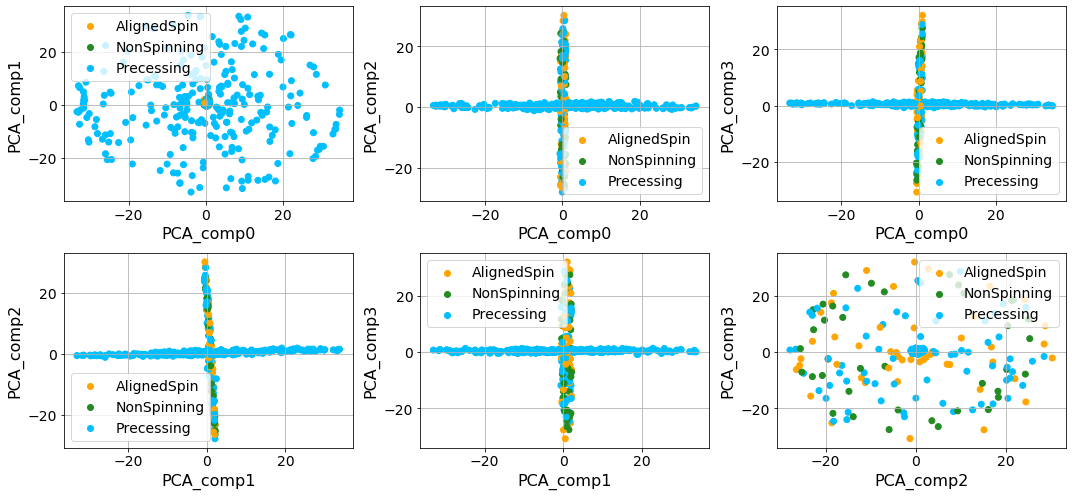




PCA for Frequency Based Data


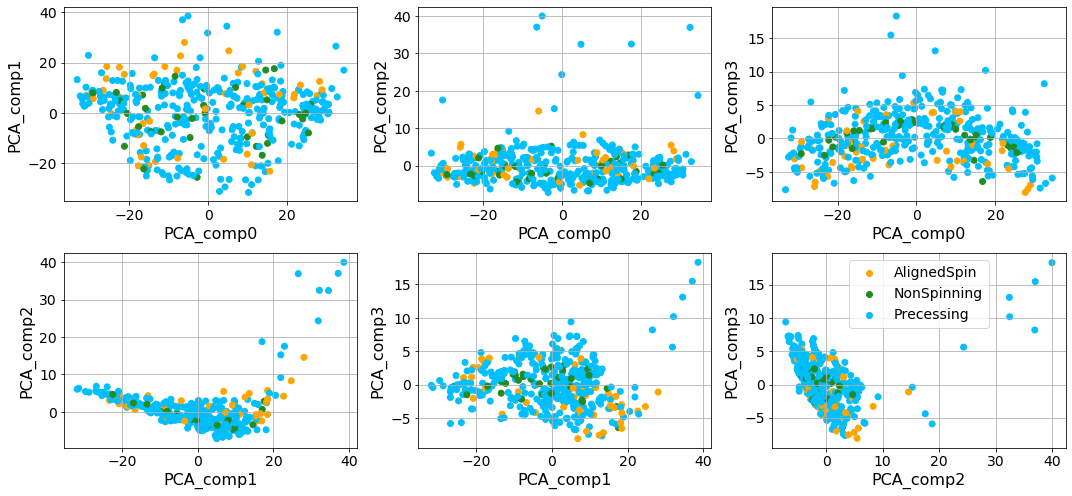

In [89]:
#PCA Continued

plt.clf
clf = PCA(svd_solver='full')
data_copy = np.copy(data_train_ht)
clf.n_components = 45
transformed_data = clf.fit_transform(data_copy)

fig, axes = plt.subplots(2,3, figsize=(15,7))
axes = axes.ravel()
k=0
print("PCA for Time Based Data")
for i in range(0,4):
    for j in  range(i+1,4):
        
        axes[k] =  scatter(axes[k], transformed_data[:,i], transformed_data[:,j],y_train_ht,"PCA_comp%d"%i, "PCA_comp%d"%j)
        k = k+1
plt.tight_layout()               
plt.show()


#PCA Continued
print('\n\n')

plt.clf
clf = PCA(svd_solver='full')
data_copy = np.copy(data_train_hf)
clf.n_components = 10
transformed_data = clf.fit_transform(data_copy)

fig, axes = plt.subplots(2,3, figsize=(15,7))
axes = axes.ravel()
k=0
print("PCA for Frequency Based Data") 
for i in range(0,4):
    for j in  range(i+1,4):
        if k==2*3-1:legend=True
        else: legend=False
        axes[k] =  scatter(axes[k], transformed_data[:,i], transformed_data[:,j],y_train_hf,"PCA_comp%d"%i, "PCA_comp%d"%j, legend=legend)
        k = k+1
plt.tight_layout()               
plt.show()


## ICA

We can also try using Independent component analysis which aims at minimizing the mutual information or mutual dependence by selecting a mutually independent basis. 

Time Based ICA


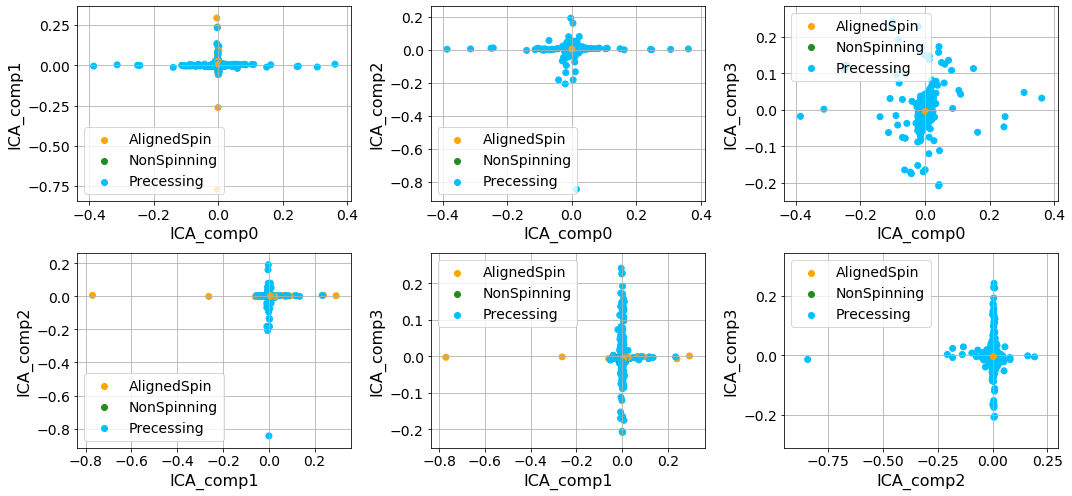

/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '




 Frequency Based ICA


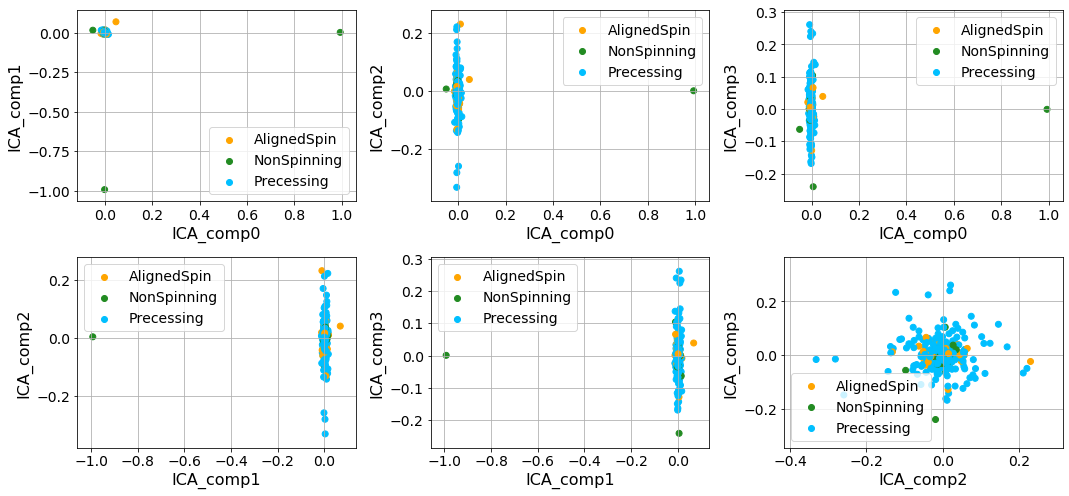

In [13]:
#ICA 

plt.clf
clf = FastICA(random_state= 12)
data_copy = np.copy(data_train_ht)
clf.n_components = 40
transformed_data = clf.fit_transform(data_copy)

fig, axes = plt.subplots(2,3, figsize=(15,7))
axes = axes.ravel()
k=0

print("Time Based ICA")
for i in range(0,3):
    for j in  range(i+1,4):
                
        axes[k] =  scatter(axes[k], transformed_data[:,i], transformed_data[:,j],y_train_ht,"ICA_comp%d"%i, "ICA_comp%d"%j)
        k = k+1
plt.tight_layout()               
plt.show()
    
    
#ICA 

plt.clf
clf = FastICA(random_state= 12)
data_copy = np.copy(data_train_hf)
clf.n_components = 40
transformed_data = clf.fit_transform(data_copy)

fig, axes = plt.subplots(2,3, figsize=(15,7))
axes = axes.ravel()
k=0
print("\n\n Frequency Based ICA")
for i in range(0,3):
        for j in  range(i+1,4):
                
                axes[k] =  scatter(axes[k], transformed_data[:,i], transformed_data[:,j],y_train_hf,"ICA_comp%d"%i, "ICA_comp%d"%j)
                k = k+1
plt.tight_layout()               
plt.show()
    

## Testing with Random Forest - 

Let's compare the above techniques with a classifier to see if dimensionality reduction works better than original data. We choose Random Forest as a test classifier to compare various dimensionality reduction techniques. We start by first comparing timeseries data with frequency series without applying any dimensionality reduction methods and then test both datasets with PCA and ICA methods. 

1. __Time-series vs Frequency Series__ - In first test, we directly apply the classifier to training dataset. We see that time series data provides better results with random forest compared to Frequency series data. With just 15 learners, we reach an accuracy of 81% on training data while an accuracy of 78% on test dataset. In comparison, frequency series data takes significantly high number of learners (~45) and still lags in performance with lower training score. 
<br>
<br>
2. __PCA Comparison__ - We next apply PCA followed by the classifier on the training and test data. As predicted, the time-series data gives best performance for about 45 components on training data but results oscillate for test dataset with increasing number of PCA compoonents. The frequency series again achieves good performance for just 15 components and then saturates out for training data while the results oscillate for test dataset. Comparing the two, we see that time series gives better results both for training and test cases compared to frequency based results. 
<br>
<br>
3. __ICA Comparison__ - ICA results are quite similar to PCA with better performance by Time series than frequency series with similar accuracies. But, in case of ICA, the results are not convergent for less than 50 components making it more expensive and slower (three times slower than PCA). Further, the average prediction score declines with increasing ICA components. Hence, this would be less preferred. 

In [46]:
%%time

#Comparing timeseries vs freqeuncy series
from sklearn.ensemble import RandomForestClassifier
print("Series Type \t Number of Learners  \t Cross Validation Score \t Test Prediction Score")
def rf_timeseries(num_learners,training_data, test_data, train_output, test_output):
    
    clf_rf = RandomForestClassifier(n_estimators=num_learners,random_state=101)
    transformed_data = clf_rf.fit(training_data, train_output)
    
    if n==10:
        prediction = clf_rf.predict(test_data)
        match  = np.size(np.where(prediction==test_output))
        print(match, match/len(prediction), clf_rf.score(test_data, test_output))
        
    cv_score = cross_val_score(clf_rf, training_data, train_output, cv=5)
    test_score = clf_rf.score(test_data, test_output)
    
    return (cv_score, test_score)
 

for num_learners in np.array((5,15,25,35,45)):

    cv_score_tseries, test_score_tseries= rf_timeseries(num_learners, data_train_ht, data_test_ht, y_train_ht, y_test_ht)
    cv_score_fseries, test_score_fseries= rf_timeseries(num_learners, data_train_hf, data_test_hf, y_train_hf, y_test_hf)


    print("Time Series \t \t {} \t \t {:.4g} \t\t\t {:.4g}".format(num_learners, np.mean(cv_score_tseries), test_score_tseries))
    print("Freq Series \t \t {} \t \t {:.4g} \t\t\t {:.4g} \n".format(num_learners, np.mean(cv_score_fseries), test_score_fseries))
    
    

Series Type 	 Number of Learners  	 Cross Validation Score 	 Test Prediction Score
Time Series 	 	 5 	 	 0.7772 			 0.726
Freq Series 	 	 5 	 	 0.7481 			 0.726 

Time Series 	 	 15 	 	 0.8112 			 0.7808
Freq Series 	 	 15 	 	 0.7723 			 0.7397 

Time Series 	 	 25 	 	 0.8184 			 0.7808
Freq Series 	 	 25 	 	 0.7868 			 0.726 

Time Series 	 	 35 	 	 0.8161 			 0.7808
Freq Series 	 	 35 	 	 0.7748 			 0.7671 

Time Series 	 	 45 	 	 0.8185 			 0.7808
Freq Series 	 	 45 	 	 0.7919 			 0.7808 

CPU times: user 5.42 s, sys: 6.7 ms, total: 5.43 s
Wall time: 5.42 s


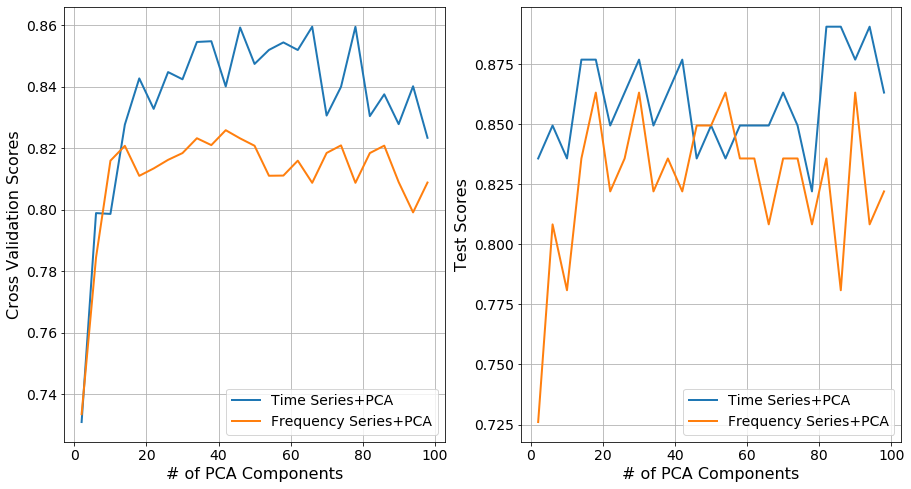

CPU times: user 47.1 s, sys: 18.2 s, total: 1min 5s
Wall time: 20 s


In [90]:
%%time

from sklearn.ensemble import RandomForestClassifier
scores, pct_var, var = [], [], []
numcomp = np.arange(2,100,4)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))

def optimize_pca(nn, train_data, test_data, train_output, test_output, nlearners=25):
    pca = PCA(svd_solver='full', n_components=nn,random_state=100)
    trainingdata_pca = pca.fit_transform(train_data)
    testdata_pca = pca.transform(test_data)
    
    clf_rf = RandomForestClassifier(n_estimators=nlearners,random_state=101)
    transformed_data = clf_rf.fit(trainingdata_pca, train_output)
    
    if n==10:
        prediction = clf_rf.predict(testdata_pca)
        match  = np.size(np.where(prediction==test_output))
        #print(match, match/len(prediction), clf_rf.score(testdata_pca, test_output))
        
    cv_score = cross_val_score(clf_rf, trainingdata_pca, train_output, cv=5)
    test_score = clf_rf.score(testdata_pca, test_output)
    
    return (cv_score, test_score)
 
crossval_scores_tseries, test_scores_tseries = [], []
crossval_scores_fseries, test_scores_fseries = [], []

for n in numcomp:
    cv_score_tseries, test_score_tseries = optimize_pca(n, data_train_ht, data_test_ht, y_train_ht, y_test_ht)
    crossval_scores_tseries.append(cv_score_tseries)
    test_scores_tseries.append(test_score_tseries)

    cv_score_fseries, test_score_fseries = optimize_pca(n, data_train_hf, data_test_hf, y_train_hf, y_test_hf, nlearners=35)
    crossval_scores_fseries.append(cv_score_fseries)
    test_scores_fseries.append(test_score_fseries)

ax1.plot(numcomp, np.mean(crossval_scores_tseries, axis=1), label='Time Series+PCA')
ax1.plot(numcomp, np.mean(crossval_scores_fseries, axis=1), label='Frequency Series+PCA')
ax1.set_xlabel('# of PCA Components')
ax1.set_ylabel('Cross Validation Scores')
ax1.legend()

ax2.plot(numcomp, test_scores_tseries, label='Time Series+PCA')
ax2.plot(numcomp, test_scores_fseries, label='Frequency Series+PCA')
ax2.set_xlabel('# of PCA Components')
ax2.set_ylabel('Test Scores')
ax2.legend()

plt.show()
plt.close()

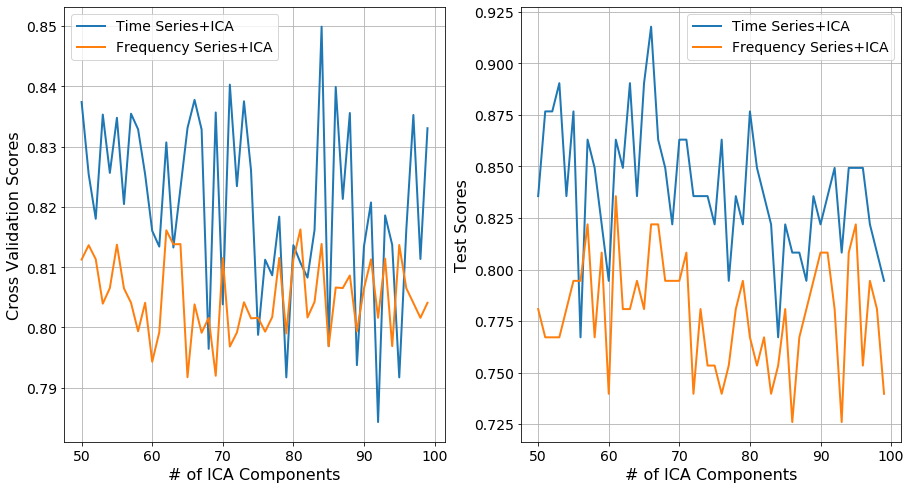

CPU times: user 2min 56s, sys: 1min 29s, total: 4min 25s
Wall time: 59.8 s


In [58]:
%%time

from sklearn.ensemble import RandomForestClassifier
scores, pct_var, var = [], [], []

#Note - ICA does not converge for num_comp lower than 50
numcomp = np.arange(50,100,1)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))

def optimize_ica(nn, train_data, test_data, train_output, test_output, nlearners=25):
    ica = FastICA(random_state= 12, n_components=nn, max_iter=300, tol=0.001)
    trainingdata_ica = ica.fit_transform(train_data)
    testdata_ica = ica.transform(test_data)
    
    clf_rf = RandomForestClassifier(n_estimators=nlearners,random_state=101)
    transformed_data = clf_rf.fit(trainingdata_ica, train_output)
    
    if n==10:
        prediction = clf_rf.predict(testdata_ica)
        match  = np.size(np.where(prediction==test_output))
        print(match, match/len(prediction), clf_rf.score(testdata_ica, test_output))
        
    cv_score = cross_val_score(clf_rf, trainingdata_ica, train_output, cv=5)
    test_score = clf_rf.score(testdata_ica, test_output)
    
    return (cv_score, test_score)
 
crossval_scores_tseries, test_scores_tseries = [], []
crossval_scores_fseries, test_scores_fseries = [], []

for n in numcomp:
    #print(n)
    cv_score_tseries, test_score_tseries = optimize_ica(n, data_train_ht, data_test_ht, y_train_ht, y_test_ht)
    crossval_scores_tseries.append(cv_score_tseries)
    test_scores_tseries.append(test_score_tseries)

    cv_score_fseries, test_score_fseries = optimize_ica(n, data_train_hf, data_test_hf, y_train_hf, y_test_hf, nlearners=35)
    crossval_scores_fseries.append(cv_score_fseries)
    test_scores_fseries.append(test_score_fseries)

ax1.plot(numcomp, np.mean(crossval_scores_tseries, axis=1), label='Time Series+ICA')
ax1.plot(numcomp, np.mean(crossval_scores_fseries, axis=1), label='Frequency Series+ICA')
ax1.set_xlabel('# of ICA Components')
ax1.set_ylabel('Cross Validation Scores')
ax1.legend()

ax2.plot(numcomp, test_scores_tseries, label='Time Series+ICA')
ax2.plot(numcomp, test_scores_fseries, label='Frequency Series+ICA')
ax2.set_xlabel('# of ICA Components')
ax2.set_ylabel('Test Scores')
ax2.legend()

plt.show()
plt.close()